# Bike share system EDA: Network 2017-Present

In [1]:
# !pip install geopy

In [2]:
# intended to be submitted via pyspark but produce results on the command line.

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, LongType
from pyspark.sql.functions import expr, col, column, lit, to_date, coalesce, to_timestamp
from geopy import distance
from pyspark.sql.functions import udf, array


import plotly.express as px

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import networkx as nx
import os

In [3]:
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

## Load data into Spark from parquet file

In [4]:
spark = SparkSession.builder.appName("Sample bike data").getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1636864884344'),
 ('spark.driver.port', '34160'),
 ('spark.driver.memory', '20g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Sample bike data'),
 ('spark.driver.host', 'DESKTOP-85CJLTL.mshome.net'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
def to_timestamp_(col, formats=("MM/dd/yyyy hh:mm:ss", "yyyy-MM-dd hh:mm:ss")):
    # Spark 2.2 or later syntax, for < 2.2 use unix_timestamp and cast
    return coalesce(*[to_timestamp(col, f) for f in formats])

@udf("double")
def to_distance(arr):
    return distance.distance((arr[0], arr[1]), (arr[2], arr[3])).miles

In [6]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

df = spark.read.load("alldata.parquet")
df.createOrReplaceTempView("bikedata")

df.show(20, False)

+------+------------------------+------------------------+----------------+---------------------------------------+------------------+------------------+--------------+----------------------------------------------------------------------+------------------+------------------+------+
|bikeid|starttime               |stoptime                |start_station_id|start_station_name                     |start_lat         |start_lng         |end_station_id|end_station_name                                                      |end_lat           |end_lng           |city  |
+------+------------------------+------------------------+----------------+---------------------------------------+------------------+------------------+--------------+----------------------------------------------------------------------+------------------+------------------+------+
|651   |2021-09-01 00:00:04.0060|2021-09-01 00:10:55.9040|93              |JFK/UMass T Stop                       |42.32033973515723 |-71.0511803

## Extract and summarize data

In [42]:
# makes assumptions lat and long are the same for stations of the same name
bike_data_sql = """
SELECT 
    start_station_name, 
    min(start_lat) as start_lat,
    min(start_lng) as start_lng,
    end_station_name, 
    min(end_lat) as end_lat,
    min(end_lng) as end_lng,
    city, 
    count(*) as trip_count
from bikedata
WHERE starttime >= cast('2017-01-01 00:00:00' AS TIMESTAMP)
GROUP BY start_station_name, end_station_name, city
"""

bike_station_df = spark.sql(bike_data_sql)
bike_station_df.createOrReplaceTempView("bikedata_station")

bike_station_df.show(20, False)

+-------------------------------------+------------------+------------------+-----------------------------------+------------------+-------------------+----+----------+
|start_station_name                   |start_lat         |start_lng         |end_station_name                   |end_lat           |end_lng            |city|trip_count|
+-------------------------------------+------------------+------------------+-----------------------------------+------------------+-------------------+----+----------+
|null                                 |37.71             |-122.37           |4th St at Mission Bay Blvd S       |37.751517666666665|-122.38768033333334|sf  |2292      |
|1 Ave & E 110 St                     |40.792327         |-73.9383          |1 Ave & E 94 St                    |40.781721         |-73.94594          |nyc |520       |
|1 Ave & E 110 St                     |40.792327         |-73.9383          |Goble Pl & Macombs Rd              |40.844075         |-73.917256         |nyc

## Compute distance

In [43]:
bike_station_df = bike_station_df.withColumn("distance", to_distance(array("start_lat", "start_lng", "end_lat", "end_lng"))) 
bike_station_df.createOrReplaceTempView("bikedata_station") 
bike_station_df.show(20, False)

+-------------------------------------+------------------+------------------+-----------------------------------+------------------+-------------------+----+----------+-------------------+
|start_station_name                   |start_lat         |start_lng         |end_station_name                   |end_lat           |end_lng            |city|trip_count|distance           |
+-------------------------------------+------------------+------------------+-----------------------------------+------------------+-------------------+----+----------+-------------------+
|null                                 |37.71             |-122.37           |4th St at Mission Bay Blvd S       |37.751517666666665|-122.38768033333334|sf  |2292      |3.0226850419281592 |
|1 Ave & E 110 St                     |40.792327         |-73.9383          |1 Ave & E 94 St                    |40.781721         |-73.94594          |nyc |520       |0.8343606307667815 |
|1 Ave & E 110 St                     |40.792327       

## Exploring Summarized Data in Pandas

In [44]:
bike_station_pd_df = bike_station_df.toPandas()

In [45]:
bike_station_pd_df.head()

start_station_name    start_lat     start_lng              end_station_name  \
0               None        37.71       -122.37  4th St at Mission Bay Blvd S   
1   1 Ave & E 110 St    40.792327      -73.9383               1 Ave & E 94 St   
2   1 Ave & E 110 St    40.792327      -73.9383         Goble Pl & Macombs Rd   
3    1 Ave & E 16 St    40.732218    -73.981655    Classon Ave & St Marks Ave   
4    1 Ave & E 16 St  40.73221853  -73.98165557        Myrtle Ave & Lewis Ave   

              end_lat              end_lng city  trip_count  distance  
0  37.751517666666665  -122.38768033333334   sf        2292  3.022685  
1           40.781721            -73.94594  nyc         520  0.834361  
2           40.844075           -73.917256  nyc           3  3.737322  
3          40.6765198          -73.9596082  nyc           7  4.013881  
4         40.69681963         -73.93756926  nyc           8  3.365146

In [46]:
bike_station_pd_df.describe()

trip_count      distance
count  1.265519e+06  1.265519e+06
mean   9.074572e+01  4.661381e+00
std    9.060754e+02  1.036492e+02
min    1.000000e+00  0.000000e+00
25%    2.000000e+00  1.575778e+00
50%    7.000000e+00  2.644805e+00
75%    3.900000e+01  3.930262e+00
max    9.275230e+05  7.959697e+03

In [ ]:
bike_station_pd_df = bike_station_pd_df.dropna()

In [160]:
bike_station_sf_pd_df = bike_station_pd_df[
    (bike_station_pd_df['city'] == 'sf')
    & (bike_station_pd_df['distance'] != 0) 
    & (bike_station_pd_df['distance'] < 10)
    & ((bike_station_pd_df['start_station_name']!='NULL') | (bike_station_pd_df['end_station_name']!='NULL'))
    & (bike_station_pd_df['start_station_name'] != bike_station_pd_df['end_station_name'])
]
bike_station_sf_pd_df.head()
bike_station_sf_pd_df.describe()

trip_count      distance
count  84531.000000  84531.000000
mean      76.979120      1.982751
std      256.948232      1.185823
min        1.000000      0.001625
25%        4.000000      1.097117
50%       15.000000      1.804497
75%       58.000000      2.644670
max    16715.000000      9.997179

In [134]:
# station = 'MTL-ECO'
# bike_station_sf_pd_df[(bike_station_sf_pd_df['start_station_name']==station) | (bike_station_sf_pd_df['end_station_name']==station)]

Empty DataFrame
Columns: [start_station_name, start_lat, start_lng, end_station_name, end_lat, end_lng, city, trip_count, distance]
Index: []

In [135]:
# station = 'MTL-ECO'
# bike_station_sf_pd_df[(bike_station_sf_pd_df['start_station_name'].str.contains(station, na=False))
#                        | (bike_station_sf_pd_df['end_station_name'].str.contains(station, na=False))]

Empty DataFrame
Columns: [start_station_name, start_lat, start_lng, end_station_name, end_lat, end_lng, city, trip_count, distance]
Index: []

In [76]:
# bike_station_sf_pd_df = bike_station_sf_pd_df[(bike_station_sf_pd_df['start_station_name'] == 'Philly Demo') |
#                                              (bike_station_sf_pd_df['end_station_name'] == 'Philly Demo') ]
# bike_station_sf_pd_df

Empty DataFrame
Columns: [start_station_name, start_lat, start_lng, end_station_name, end_lat, end_lng, city, trip_count, distance]
Index: []

## Explore station network plots

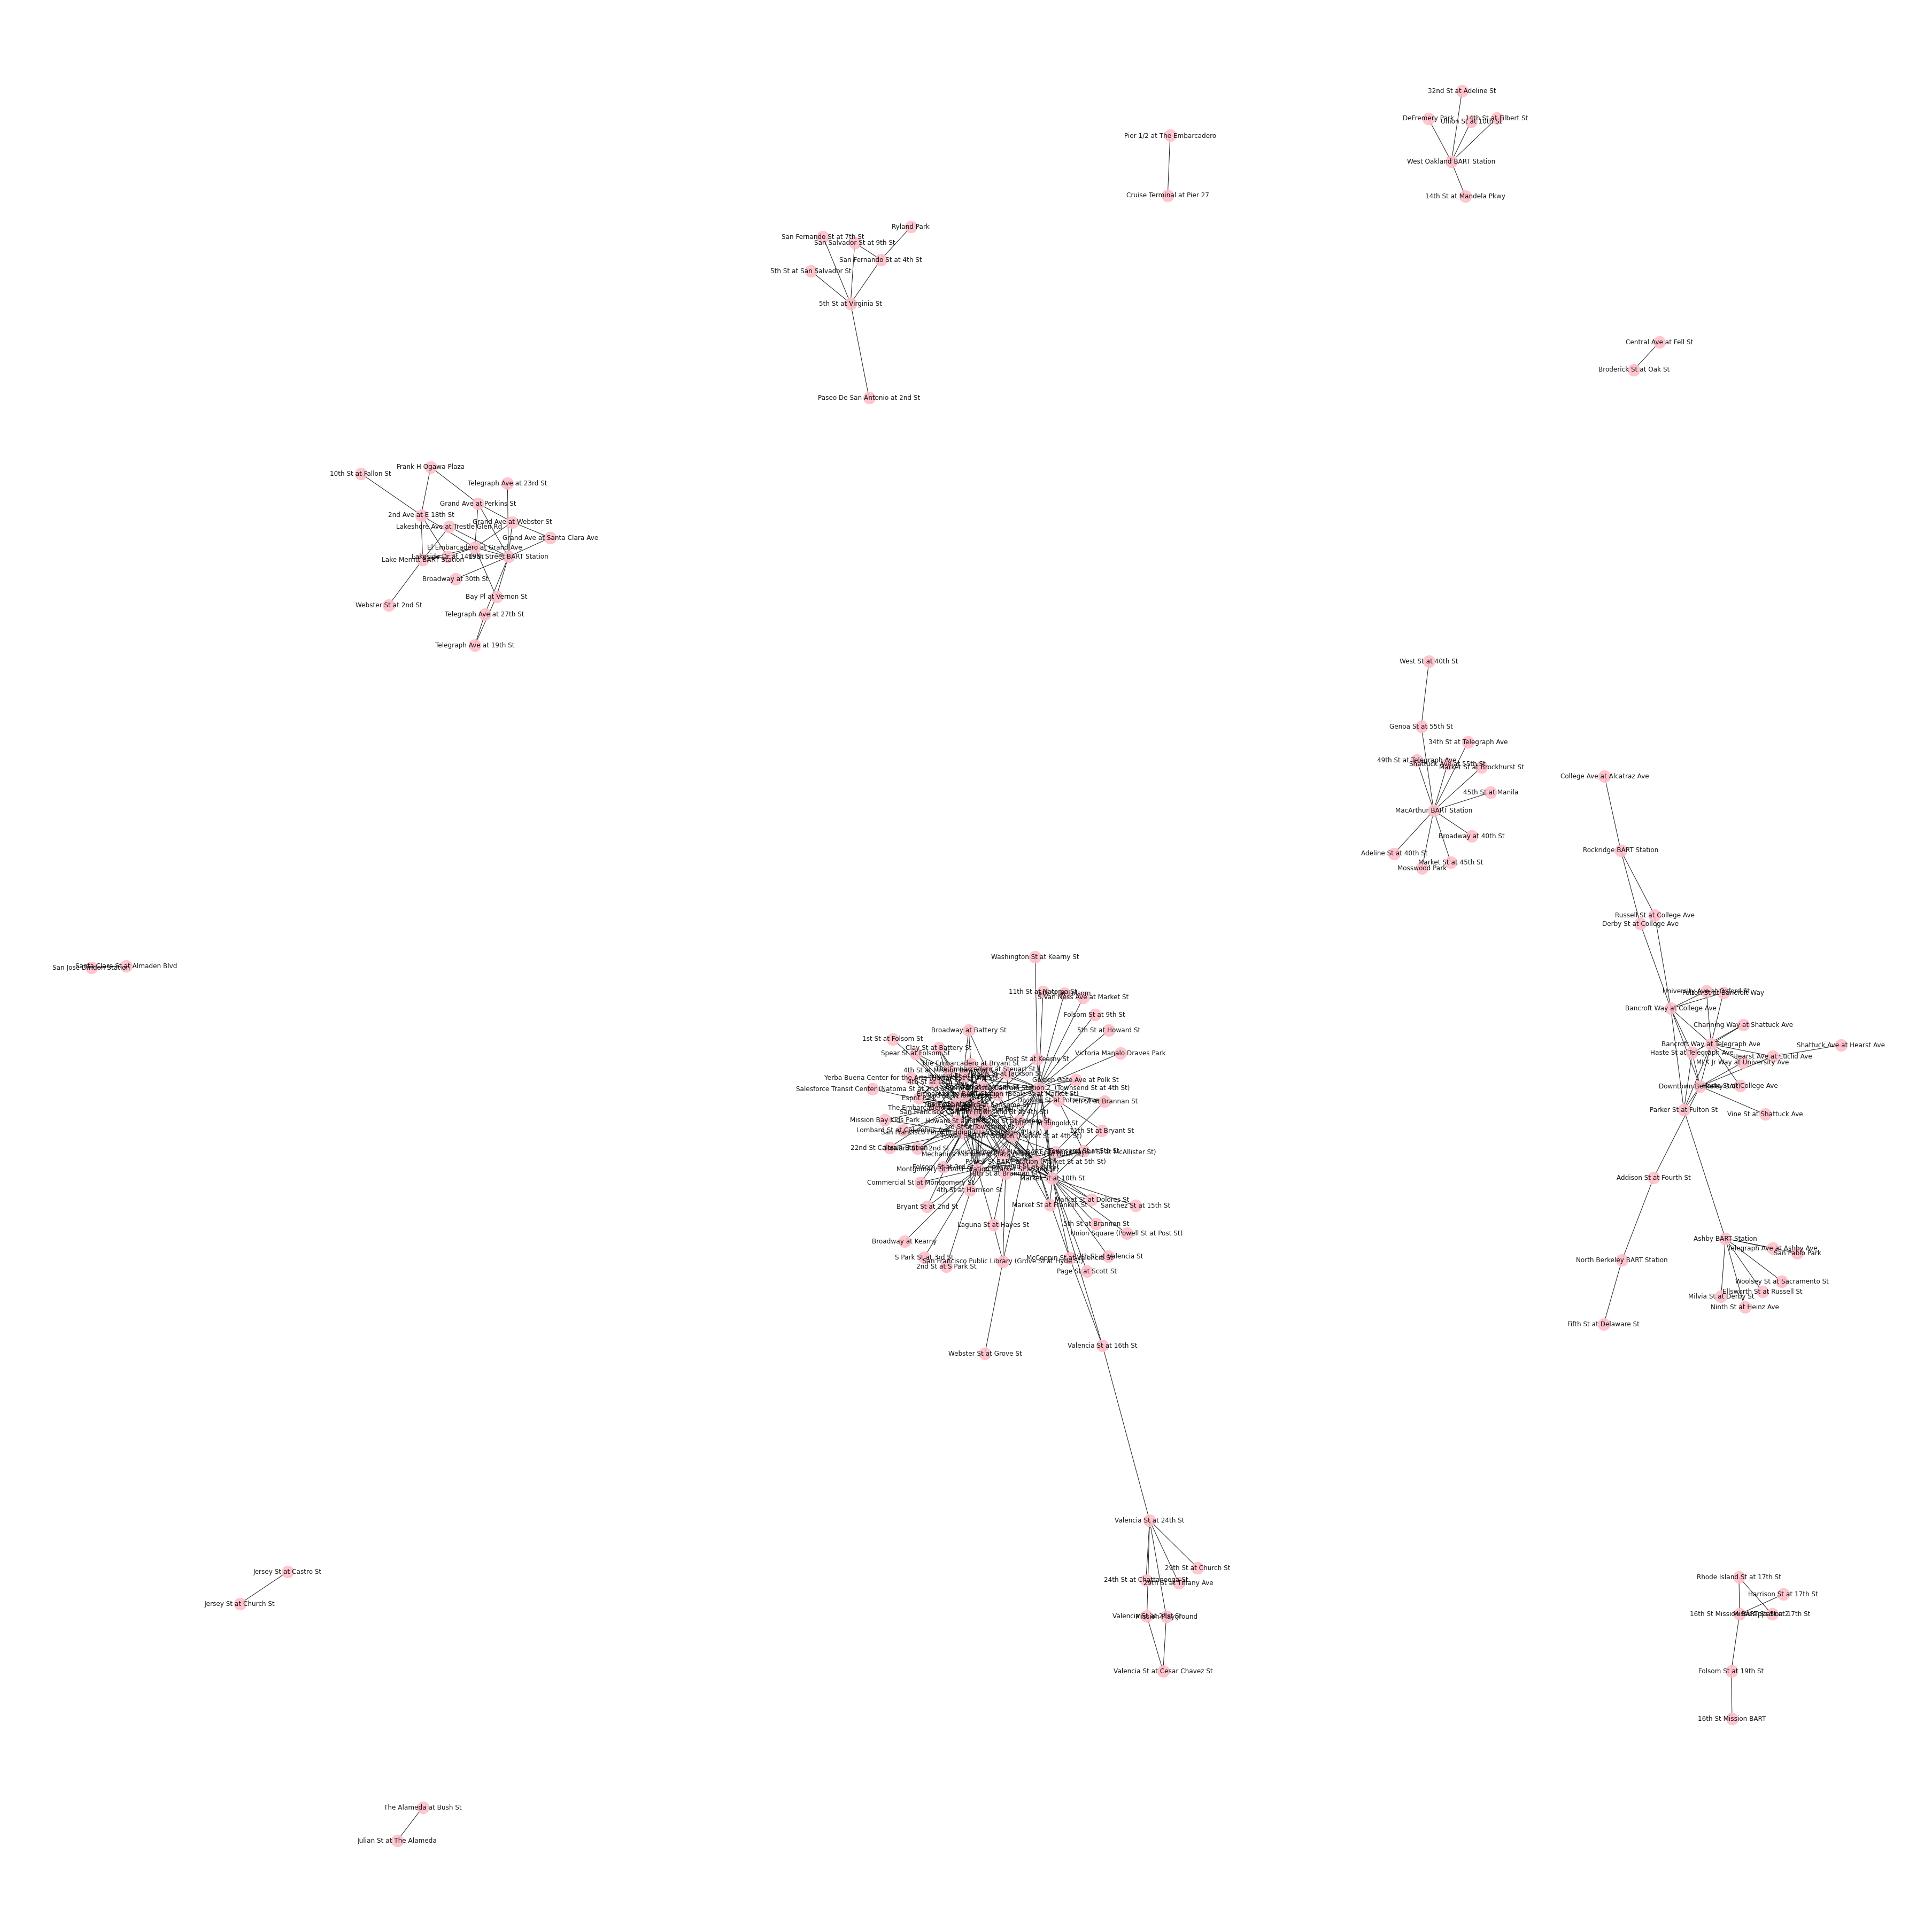

In [184]:
G = nx.from_pandas_edgelist(bike_station_sf_pd_df.nlargest(500, 'trip_count'),
                            "start_station_name", "end_station_name",
                            edge_attr='distance')

pos = nx.spring_layout(G)
# pos = nx.spectral_layout(G)

plt.figure(figsize=(50,50))
nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()})

# plt.axis('off')
plt.show()

In [172]:
nyc_station_filter = ['BD Mobile 01', 'BD QC Station 01', '8D Mobile 01', '8D QC Station 01']

bike_station_nyc_pd_df = bike_station_pd_df[
    (bike_station_pd_df['city'] == 'nyc')
    & (bike_station_pd_df['distance'] != 0) 
#     & (bike_station_pd_df['distance'] > 1) 
    & (bike_station_pd_df['distance'] < 10)
#     & (bike_station_pd_df['trip_count'] > 1000)
    & ((bike_station_pd_df['start_station_name']!='NULL') | (bike_station_pd_df['end_station_name']!='NULL'))
    & (bike_station_pd_df['start_station_name'] != bike_station_pd_df['end_station_name'])
    & (~bike_station_pd_df['start_station_name'].isin(nyc_station_filter))
    & (~bike_station_pd_df['end_station_name'].isin(nyc_station_filter))
#     & ~(bike_station_pd_df['start_station_name'].str.contains('MTL-ECO', na=False))
#                        | (bike_station_pd_df['end_station_name'].str.contains(station, na=False))
]
bike_station_nyc_pd_df.head()
bike_station_nyc_pd_df.describe()

trip_count      distance
count  1.057263e+06  1.057263e+06
mean   8.803872e+01  3.006007e+00
std    3.633149e+02  1.748684e+00
min    1.000000e+00  2.112883e-06
25%    2.000000e+00  1.651166e+00
50%    7.000000e+00  2.770065e+00
75%    3.600000e+01  4.076157e+00
max    2.781600e+04  9.999973e+00

In [185]:
# station = '8D'
# bike_station_nyc_pd_df[(bike_station_nyc_pd_df['start_station_name'].str.contains(station, na=False))
#                        | (bike_station_nyc_pd_df['end_station_name'].str.contains(station, na=False))]

C:\Users\Gordon\.conda\envs\cscie63\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Gordon\.conda\envs\cscie63\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


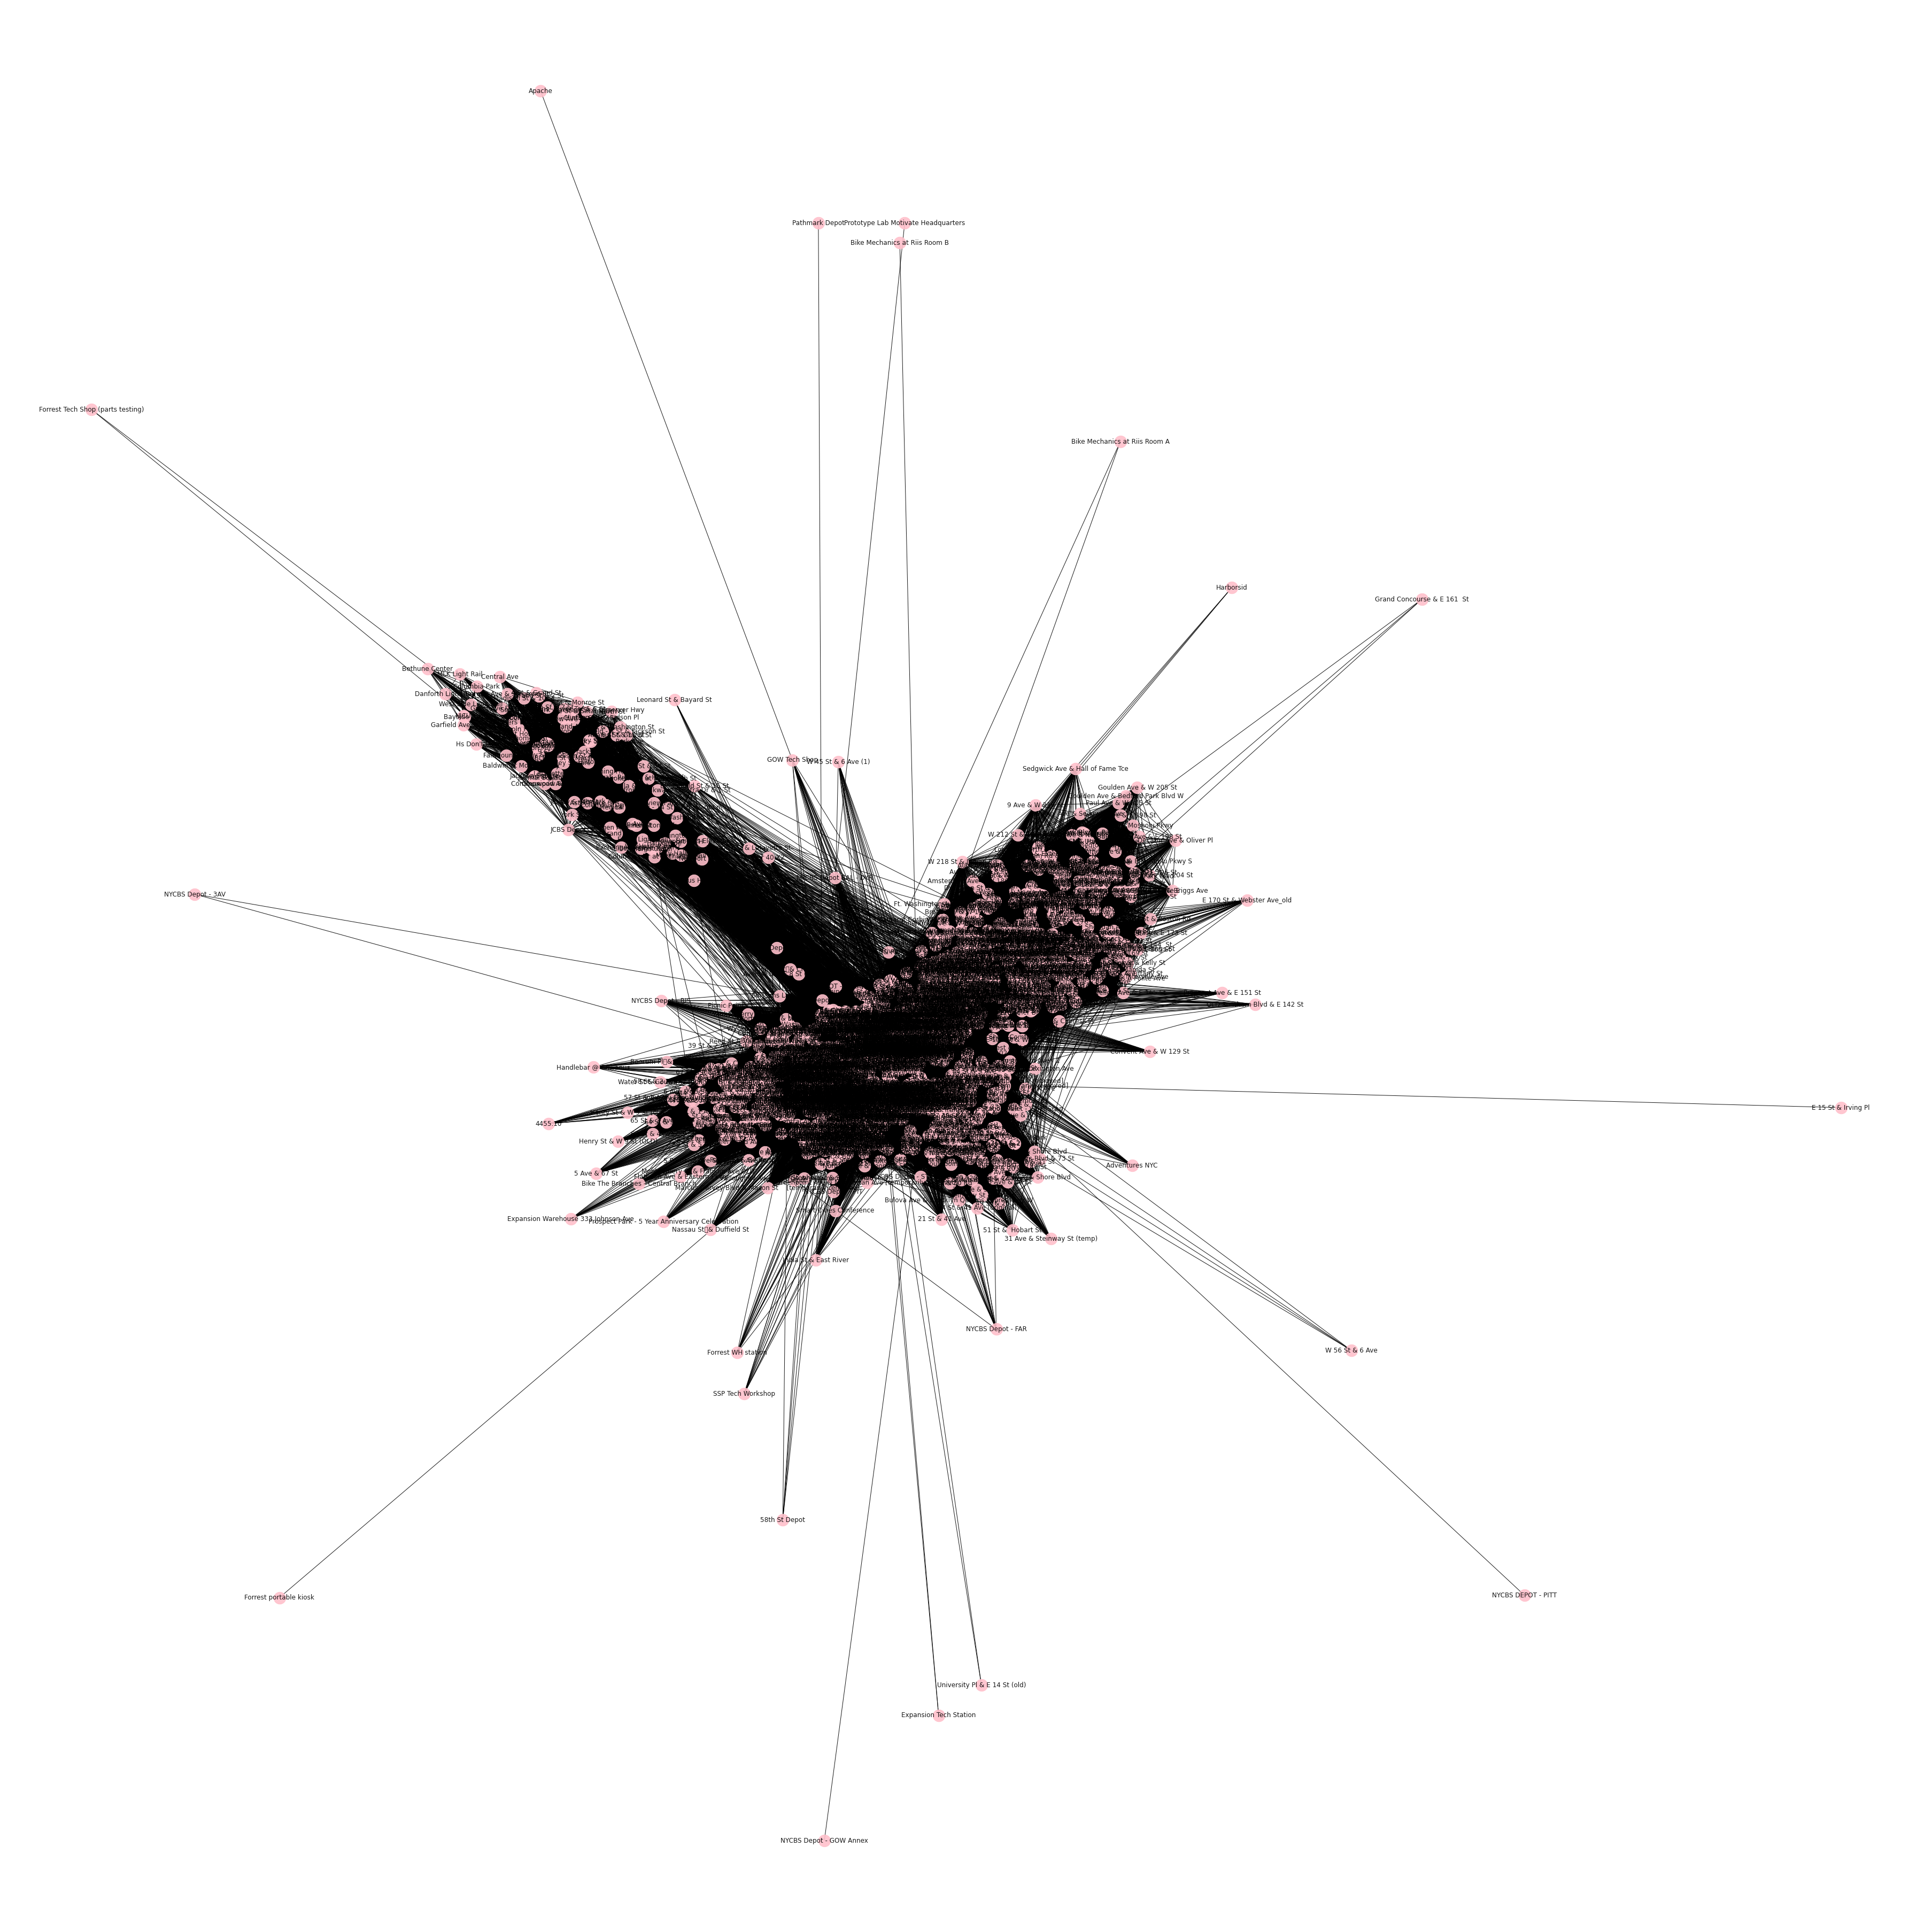

In [202]:
# G = nx.from_pandas_edgelist(bike_station_nyc_pd_df.nlargest(500, 'trip_count'),
#                             "start_station_name", "end_station_name",
#                             edge_attr='distance')

G = nx.from_pandas_edgelist(bike_station_nyc_pd_df,
                            "start_station_name", "end_station_name",
                            edge_attr='distance')


pos = nx.spring_layout(G)
# pos = nx.spectral_layout(G)

plt.figure(figsize=(50,50))
nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()})

# plt.axis('off')
plt.show()

In [188]:
boston_station_filter = []

bike_station_boston_pd_df = bike_station_pd_df[
    (bike_station_pd_df['city'] == 'boston')
    & (bike_station_pd_df['distance'] != 0) 
#     & (bike_station_pd_df['distance'] > 1) 
    & (bike_station_pd_df['distance'] < 10)
#     & (bike_station_pd_df['trip_count'] > 1000)
    & ((bike_station_pd_df['start_station_name']!='NULL') | (bike_station_pd_df['end_station_name']!='NULL'))
    & (bike_station_pd_df['start_station_name'] != bike_station_pd_df['end_station_name'])
    & (~bike_station_pd_df['start_station_name'].isin(boston_station_filter))
    & (~bike_station_pd_df['end_station_name'].isin(boston_station_filter))
#     & ~(bike_station_pd_df['start_station_name'].str.contains('MTL-ECO', na=False))
#                        | (bike_station_pd_df['end_station_name'].str.contains(station, na=False))
]
bike_station_boston_pd_df.head()
bike_station_boston_pd_df.describe()

trip_count       distance
count  115516.000000  115516.000000
mean       80.827124       2.542713
std       307.135971       1.338914
min         1.000000       0.002302
25%         2.000000       1.519336
50%        10.000000       2.401727
75%        52.000000       3.412025
max     17793.000000       9.769210

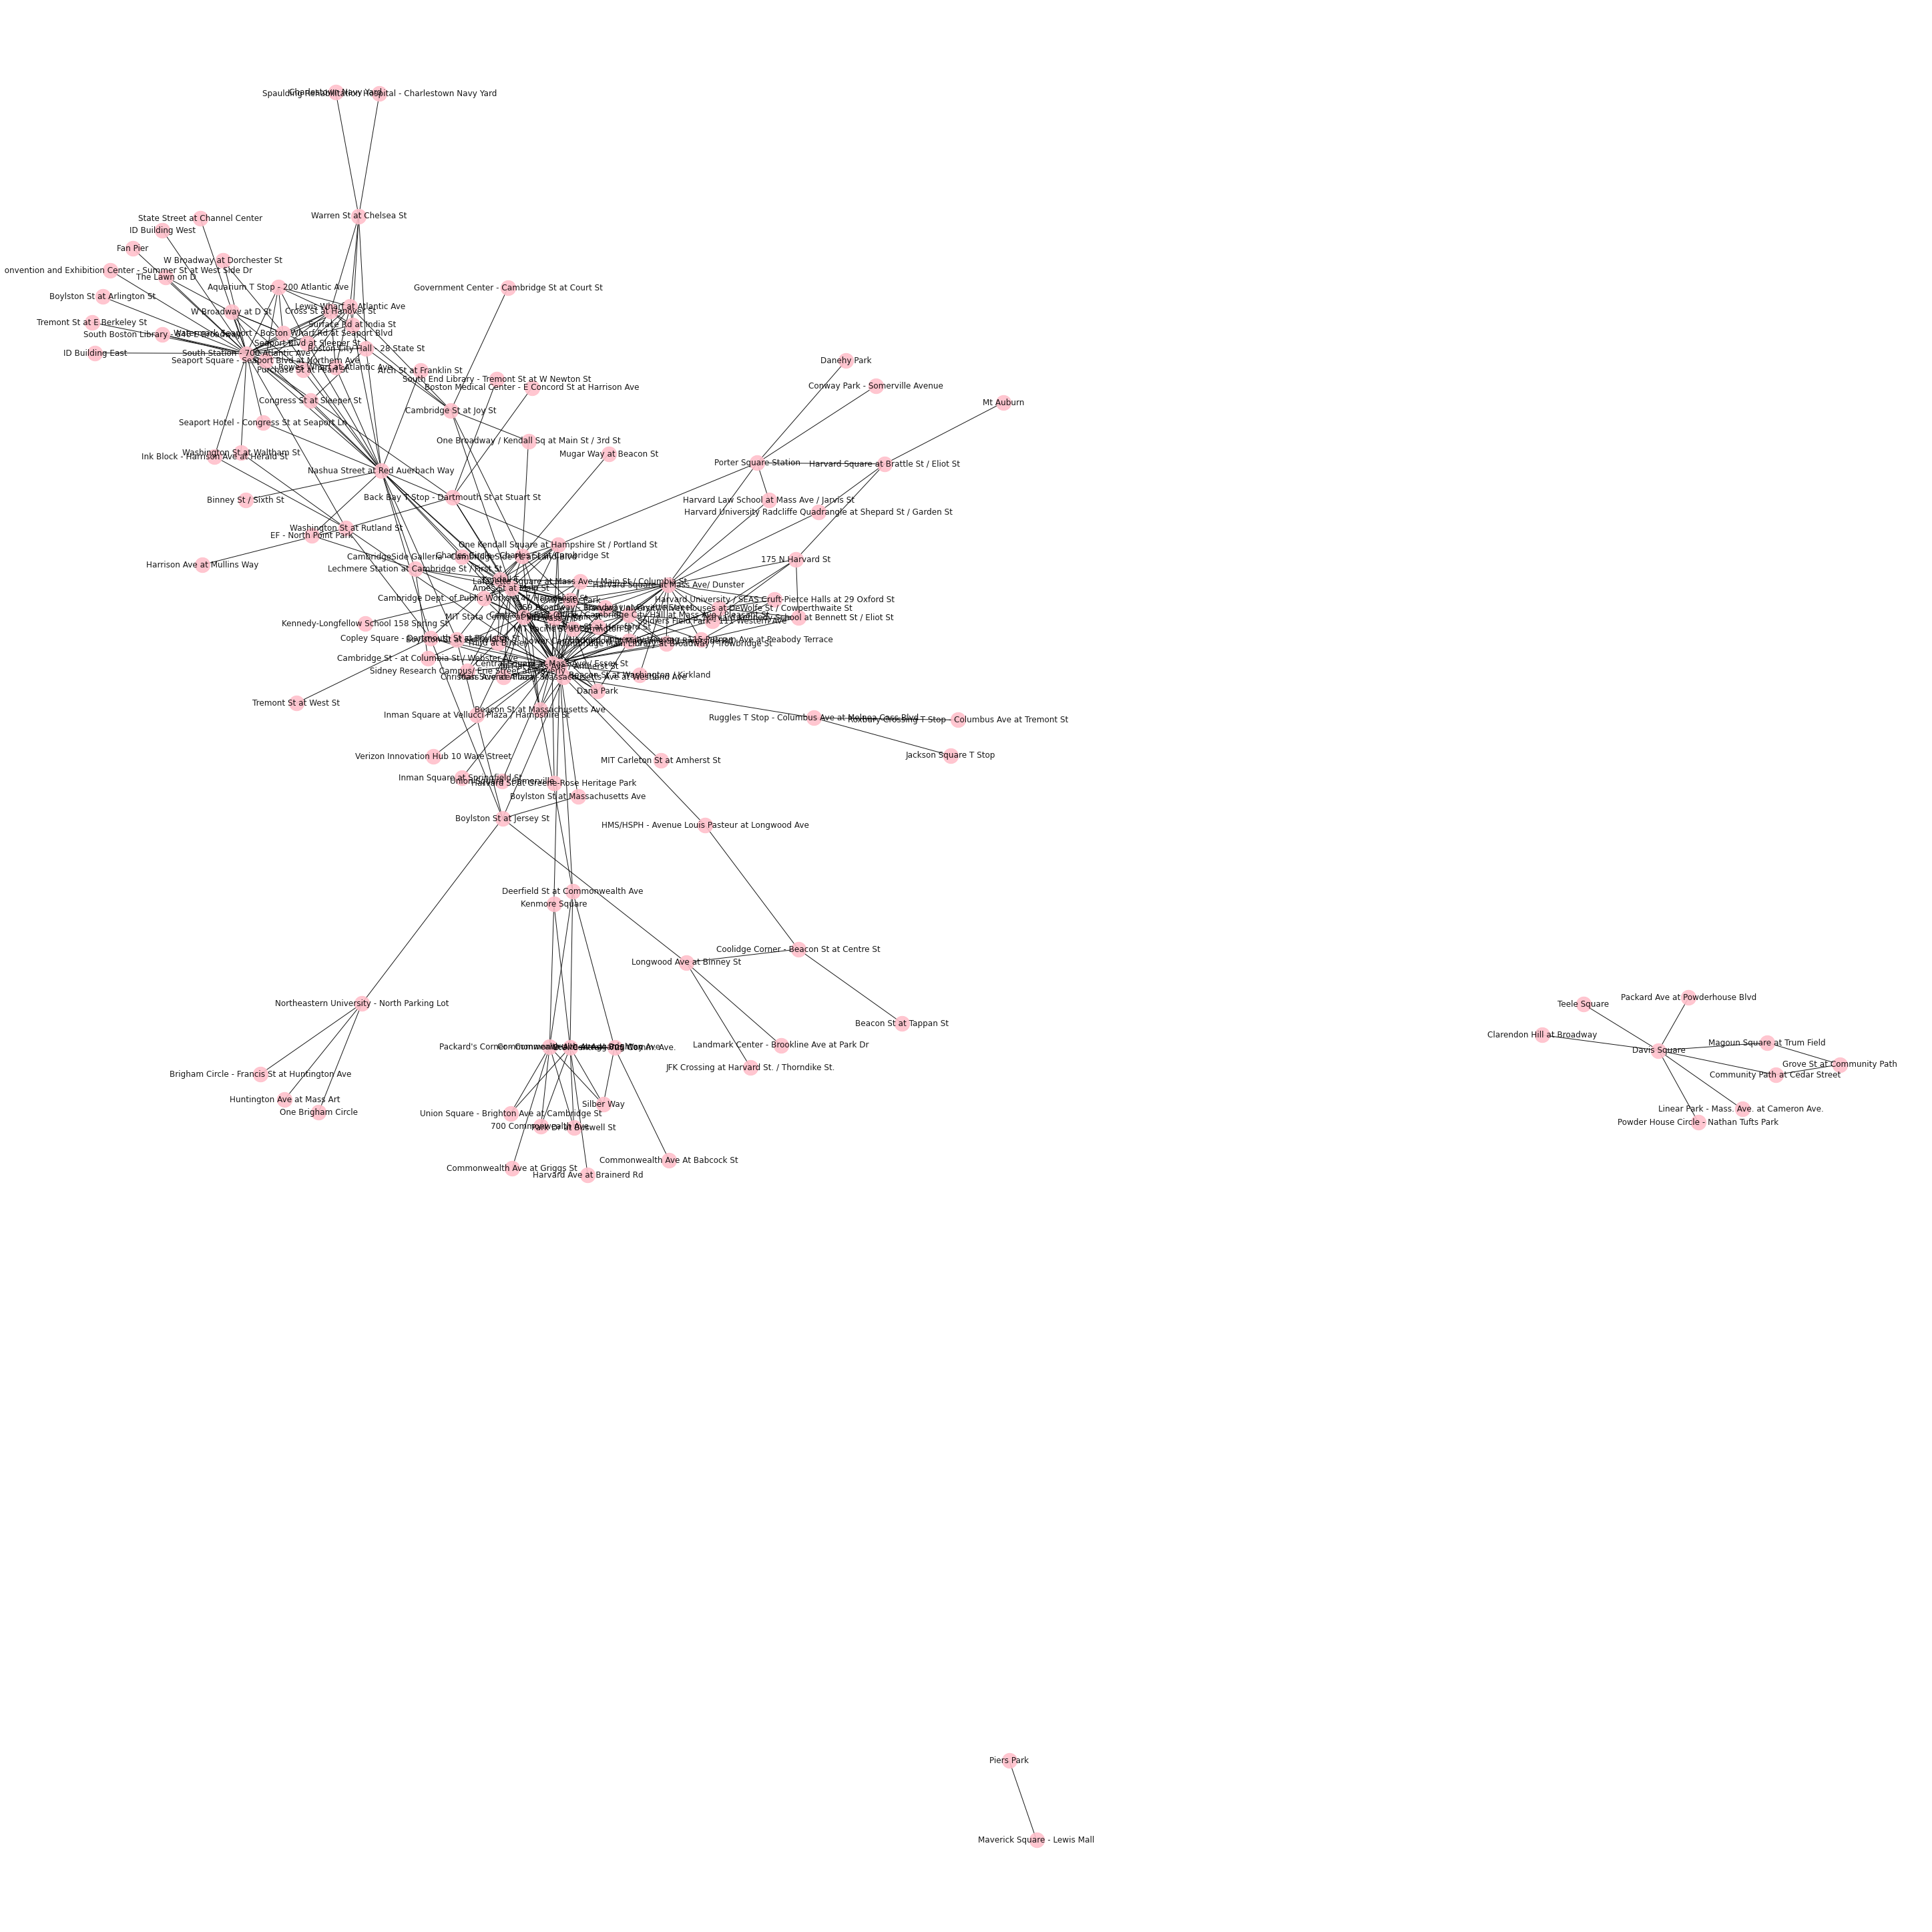

In [201]:
G = nx.from_pandas_edgelist(bike_station_boston_pd_df.nlargest(500, 'trip_count'),
                            "start_station_name", "end_station_name",
                            edge_attr='distance')

pos = nx.spring_layout(G)
# pos = nx.spectral_layout(G)

plt.figure(figsize=(40,40))
nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()})

# plt.axis('off')
plt.show()